# Conditional GAN (cGAN)

## Imports e FID

In [1]:
import torch
import torchvision
import torch.utils.data.dataloader as dataloader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import time

if torch.cuda.is_available():
    device = "cuda:0"
else:
    device = "cpu"

print(f"Running on {device}")

Running on cuda:0


* Código obtido de https://pytorch.org/hub/pytorch_vision_inception_v3/
* O seguinte link menciona como converter de Grayscale para o RGB visualmente equivalente (https://discuss.pytorch.org/t/grayscale-to-rgb/94639/2)
* Implementação do FID retirada de https://machinelearningmastery.com/how-to-implement-the-frechet-inception-distance-fid-from-scratch/

In [2]:
## code taken from https://pytorch.org/hub/pytorch_vision_inception_v3/
model_inceptionV3 = torchvision.models.inception_v3(weights=torchvision.models.Inception_V3_Weights.DEFAULT).to(device)
model_inceptionV3.eval() # evaluation/inference mode

preprocess = transforms.Compose([
    transforms.Lambda(lambda img: img.expand(-1, 3, -1, -1)),  # Acts on batch. From grayscale to RGB with R=G=B = original channel intensity
    transforms.Resize(299),
    transforms.CenterCrop(299),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [3]:
# remove fc layers
model_inceptionV3._modules["dropout"] = nn.Identity()
model_inceptionV3._modules["fc"] = nn.Identity()

print(f"Total parameters: {sum(x.numel() for x in model_inceptionV3.parameters() if x.requires_grad)}")

Total parameters: 25112264


In [4]:
from scipy.linalg import sqrtm # principal square root of positive (semi)definite matrix

def FID_score(real_batch: torch.Tensor, fake_batch: torch.Tensor):
    act1 = preprocess(real_batch).to(device)
    act2 = preprocess(fake_batch).to(device)

    ## inference only
    with torch.no_grad():
        act1 = model_inceptionV3(act1)
        act2 = model_inceptionV3(act2)

    ## pass to cpu and then convert to numpy array
    act1 = act1.cpu().detach().numpy()
    act2 = act2.cpu().detach().numpy()

    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)

    mean_dist_square = np.sum((mu1 - mu2)**2)
    sqrt_cov = sqrtm(sigma1.dot(sigma2))
    if np.iscomplexobj(sqrt_cov):
        sqrt_cov = sqrt_cov.real

    return mean_dist_square + np.trace(sigma1 + sigma2 - 2.0 * sqrt_cov)

## 0. Parameters

In [5]:
# parameters
# root = "/home/igor/IC-iVision/CIFAR10"
root = "/home/igor/IC-iVision/MNIST"
img_size = (28, 28)
batch_size = 25
workers = 0

In [6]:
num_classes = 10
nc = 1 # num channels
nz = 100
n_embed = 10
leaky_slope = 0.2
lr = 0.0002
betas=(0.5, 0.999)
g_hidden_layers = [128, 256, 512, 1024, 2048, 4096]
d_hidden_layers = [2048, 4096, 2048, 512, 256]
criterion = nn.BCELoss() # y log x + (1 - y) log (1 - x) where x,y are of shape (batch_size,)
# criterion = nn.MSELoss()

## 1. Loading

In [7]:
## loading

## use only training images to make loading easier
dataset = datasets.MNIST(root=root, train=True,
                           transform=transforms.Compose([
                               # transforms.CenterCrop(img_size),
                               transforms.ToTensor(),
                               transforms.Resize(img_size),
                               # transforms.Normalize([0.5], [0.5]), # normalize single channel
                               transforms.Grayscale()
                           ]),
                           download=True)

print(f"Loaded {len(dataset)} images of {len(dataset.classes)} classes")
print("Classes:", *dataset.classes, sep="\n\t")

dl = dataloader.DataLoader(dataset, batch_size=batch_size,
                           shuffle=True,
                           num_workers=workers)

Loaded 60000 images of 10 classes
Classes:
	0 - zero
	1 - one
	2 - two
	3 - three
	4 - four
	5 - five
	6 - six
	7 - seven
	8 - eight
	9 - nine


### 1.2 Plotting one batch

/home/igor/.local/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


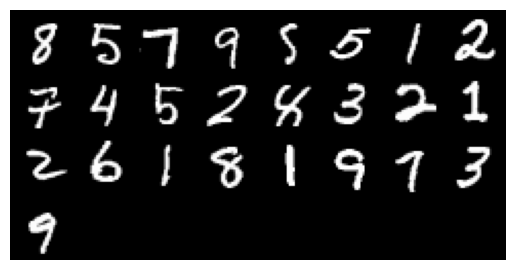

FID score of -8.521705243184625e-05. Expected 0.0.


In [8]:
img_batch, labels = next(iter(dl))

# plt.rcParams["figure.figsize"] = (20, 20)

img_grid = vutils.make_grid(img_batch, 8)
img_grid = np.transpose(img_grid, (1, 2, 0))
plt.axis("off")

plt.imshow(img_grid)
plt.show()

print(f"FID score of {FID_score(img_batch, img_batch)}. Expected 0.0.") ## for FID testing purposes

## 2. Creating network

### 2.1 Generator

In [9]:
class cGenerator(nn.Module):
    def __init__(self):
        super(cGenerator, self).__init__()
        self.all_layers = [nz + n_embed] + g_hidden_layers
        self.main = nn.ModuleList()
        for i in range(len(self.all_layers) - 1):
            in_size = self.all_layers[i]
            out_size = self.all_layers[i + 1]
            self.main.append(nn.Linear(in_features=in_size, out_features=out_size))
            self.main.append(nn.BatchNorm1d(out_size))
            self.main.append(nn.LeakyReLU(negative_slope=leaky_slope, inplace=True))
        self.main.append(nn.Linear(self.all_layers[-1], nc * img_size[0] * img_size[1]))
        self.main.append(nn.Tanh())

        self.embedding = nn.Embedding(num_embeddings=num_classes, embedding_dim=n_embed)

    def forward(self, z, y):
        embedded_y = self.embedding(y)
        tensor = torch.cat([z, embedded_y], dim=-1)
        for layer in self.main:
            tensor = layer(tensor)
        return tensor.view(-1, nc, img_size[0], img_size[1])

In [10]:
netG = cGenerator().to(device) # generator on GPU

optimG = optim.Adam(params=netG.parameters(), lr=lr, betas=betas)

In [11]:
print(netG)
print(f"Total parameters: {sum(x.numel() for x in netG.parameters() if x.requires_grad)}")

cGenerator(
  (main): ModuleList(
    (0): Linear(in_features=110, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Linear(in_features=128, out_features=256, bias=True)
    (4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Linear(in_features=256, out_features=512, bias=True)
    (7): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Linear(in_features=512, out_features=1024, bias=True)
    (10): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
    (12): Linear(in_features=1024, out_features=2048, bias=True)
    (13): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_runni

### 2.2 Discriminator

In [12]:
class cDiscriminator(nn.Module):
    def __init__(self):
        super(cDiscriminator, self).__init__()
        self.all_layers = [nc * img_size[0] * img_size[1] + n_embed] + d_hidden_layers
        self.main = nn.ModuleList()
        for i in range(len(self.all_layers) - 1):
            in_size = self.all_layers[i]
            out_size = self.all_layers[i + 1]
            self.main.append(nn.Linear(in_features=in_size, out_features=out_size))
            self.main.append(nn.LeakyReLU(negative_slope=leaky_slope, inplace=True))
        self.main.append(nn.Linear(self.all_layers[-1], 1))
        self.main.append(nn.Sigmoid())

        self.embedding = nn.Embedding(num_embeddings=num_classes, embedding_dim=n_embed)

    def forward(self, x, y):
        flattened_x = torch.flatten(x, 1)
        embedded_y = self.embedding(y)
        tensor = torch.cat([flattened_x, embedded_y], dim=-1)
        for layer in self.main:
            tensor = layer(tensor)
        return tensor

In [13]:
netD = cDiscriminator().to(device) # discriminator on GPU

optimD = optim.Adam(params=netD.parameters(), lr=lr, betas=betas)

In [14]:
print(netD)
print(f"Total parameters: {sum(x.numel() for x in netD.parameters() if x.requires_grad)}")

cDiscriminator(
  (main): ModuleList(
    (0): Linear(in_features=794, out_features=2048, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=2048, out_features=4096, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Linear(in_features=4096, out_features=2048, bias=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Linear(in_features=2048, out_features=512, bias=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Linear(in_features=512, out_features=256, bias=True)
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): Linear(in_features=256, out_features=1, bias=True)
    (11): Sigmoid()
  )
  (embedding): Embedding(10, 10)
)
Total parameters: 19592293


## 3 Training

### 3.1 Some definitions

In [15]:
def plot_side_by_side(img_batch, labels_batch):
    plt.rcParams["figure.figsize"] = (20, 20)
    plt.subplots_adjust(wspace=1.0, hspace=1.0)

    fig, ax = plt.subplots(1, 2)

    noise = torch.randn(batch_size, nz, device=device)
    with torch.no_grad():
        fake_batch = netG(noise.to(device), labels_batch.to(device)).cpu()

    real_grid = torchvision.utils.make_grid(img_batch.cpu(), 8, normalize=True) # image grid
    real_grid = np.transpose(real_grid, (1, 2, 0)) # reshape images from [num_channels, H, W] to [H, W, num_channels]
    ax[0].set_title("Batch of real images")
    ax[0].imshow(real_grid, cmap="gray")
    ax[0].axis("off")

    fake_grid = torchvision.utils.make_grid(fake_batch, 8, normalize=True) # image grid
    fake_grid = np.transpose(fake_grid, (1, 2, 0)) # reshape images from [num_channels, H, W] to [H, W, num_channels]
    ax[1].set_title("Batch of generated images")
    ax[1].imshow(fake_grid, cmap="gray")
    ax[1].axis("off")

    plt.show()

In [16]:
# training loop
D_losses = []
D_reals = []
D_fakes = []
G_losses = []
fid = []
num_epochs = 0

In [17]:
num_batches = len(dataset) // batch_size

### 3.2 Training loop

In [18]:
def train(curr_epochs: int, D_losses: list, D_reals: list, D_fakes: list, G_losses: list, fid: list, * ,
          max_time_sec: float = float('inf'), max_epochs: int = 10_000):
    init_time = time.time()
    for i in range(max_epochs):
        D_loss_epoch = 0.0
        D_real_mean = 0.0
        D_fake_mean = 0.0
        G_loss_epoch = 0.0

        for img_batch, y_batch in dl:
            noise = torch.randn([batch_size, nz], device=device)
            conditional_noise = torch.randint(0, num_classes, (batch_size,), device=device)

            img_batch = img_batch.to(device) # load images in GPU
            y_batch = y_batch.to(device) # load labels to GPU
            fake_img_batch = netG(noise, y_batch)
            real_label_vector = torch.full((batch_size,), 1, dtype=torch.float, device=device)
            fake_label_vector = torch.full((batch_size,), 0, dtype=torch.float, device=device)

            # ----- Train discriminator --------
            # zero all gradients
            netD.zero_grad()

            # - 1/m * sum log D(xi)
            real_output = netD(img_batch, y_batch).view(-1)
            D_real_loss = criterion(real_output, real_label_vector)
            D_real_loss.backward() # calcuate gradient
            # - 1/m * sum log (1 - D(G(zi)))
            # the detach makes it ignore the NetG parameter in gradient computation graph
            # (since fake_img_batch = NetG(noise))
            fake_output = netD(fake_img_batch.detach(), conditional_noise).view(-1)
            D_fake_loss = criterion(fake_output, fake_label_vector)
            D_fake_loss.backward() # calculate (and accumulate) gradient
            # maximize 1/m * sum log D(xi) + 1/m * sum log (1 - D(G(zi)))
            optimD.step()
            # accumulate loss
            D_loss_epoch += D_real_loss.item() + D_fake_loss.item()
            # accumulate real and fake outputs
            D_real_mean += real_output.sum().item()
            D_fake_mean += fake_output.sum().item()

            # zero all gradients
            netG.zero_grad()

            # - 1/m * sum log D(G(z))
            # now fake_img_batch should be a part of the gradient computation graph
            fake_output = netD(fake_img_batch, conditional_noise).view(-1)
            G_loss = criterion(fake_output, real_label_vector)
            G_loss.backward() # calculate gradient
            # maximize 1/m sum log D(G(z)) ==> minimize 1/m sum log(1 - D(G(z)))
            optimG.step()
            # accumulate loss
            G_loss_epoch += G_loss.item()

        D_real_mean /= batch_size * num_batches # avg D(x)
        D_fake_mean /= batch_size * num_batches # avg D(G(z))

        print(f"Epoch {i + 1}. Generator loss: {G_loss_epoch}. " +
            f"Discriminator loss: {D_loss_epoch}. " +
            f"Average D(x): {D_real_mean}. Average D(G(z)): {D_fake_mean}")

        ## calculate FID
        img_batch, _ = next(iter(dl)) # get new (random?) batch
        noise = torch.randn([batch_size, nz], device=device)
        conditional_noise = torch.randint(0, num_classes, (batch_size,), device=device)
        fake_img_batch = netG(noise, y_batch)
        fid_epoch = FID_score(img_batch, fake_img_batch)
        print(f"FID score for random batch: {fid_epoch}")

        # save for plotting latter
        D_losses.append(D_loss_epoch)
        D_reals.append(D_real_mean)
        D_fakes.append(D_fake_mean)
        G_losses.append(G_loss_epoch)
        fid.append(fid_epoch)
        curr_epochs += 1

        # plot every 3 epochs
        if (i % 3 == 0):
            img_batch, y_batch = next(iter(dl)) # get new (random?) batch
            plot_side_by_side(img_batch, y_batch)

        # check time
        if (time.time() - init_time > max_time_sec):
            return D_losses, D_reals, D_fakes, G_losses, fid, curr_epochs

    return D_losses, D_reals, D_fakes, G_losses, fid, curr_epochs

Epoch 1. Generator loss: 40607.98842692375. Discriminator loss: 794.1761212545398. Average D(x): 0.8964716548124949. Average D(G(z)): 0.09225288990571534
FID score for random batch: 394.706363483848


<Figure size 2000x2000 with 0 Axes>

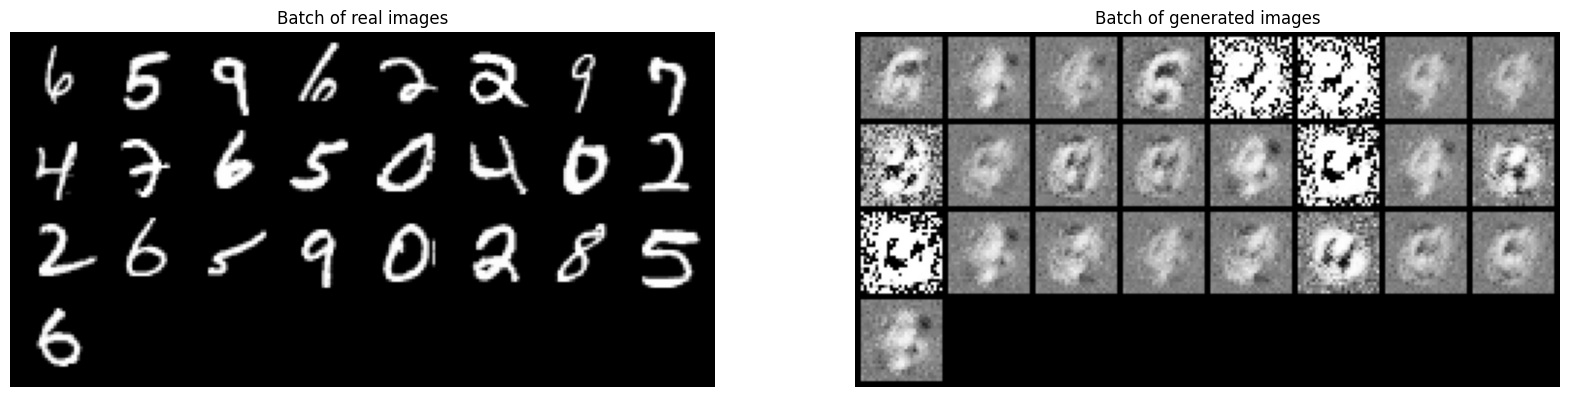

Epoch 2. Generator loss: 32752.36516714096. Discriminator loss: 463.41333651197147. Average D(x): 0.9443610069036483. Average D(G(z)): 0.05208615420867078
FID score for random batch: 384.72959864701056
Epoch 3. Generator loss: 46081.703217983246. Discriminator loss: 294.98120457763366. Average D(x): 0.9658193162600199. Average D(G(z)): 0.032810114806011356
FID score for random batch: 407.587228568055
Epoch 4. Generator loss: 55298.32341146469. Discriminator loss: 239.33006323880187. Average D(x): 0.9725563330332438. Average D(G(z)): 0.026757045164830507
FID score for random batch: 421.3123136920195


<Figure size 2000x2000 with 0 Axes>

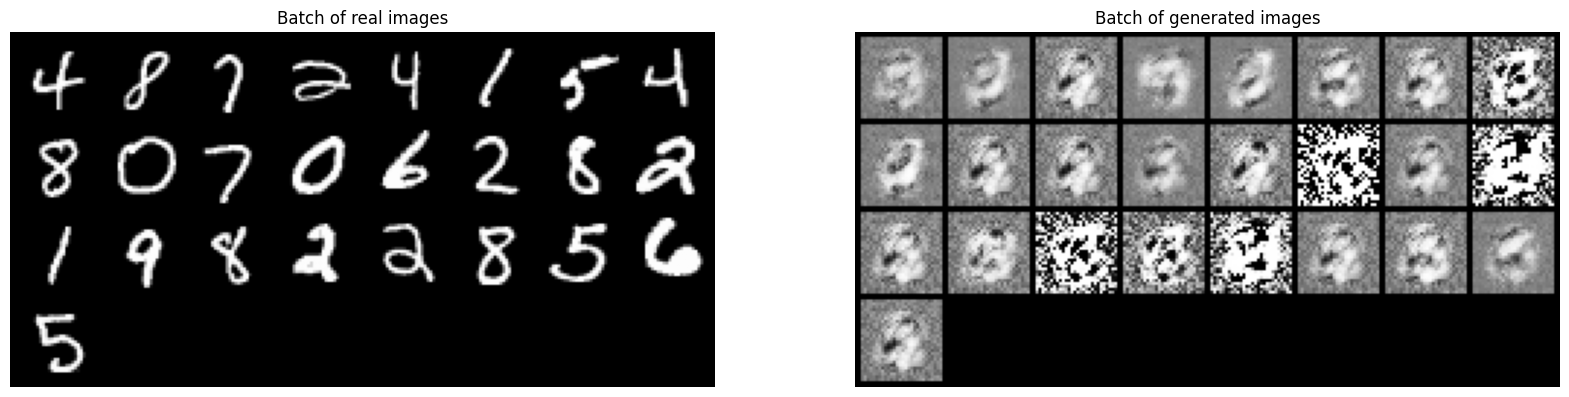

Epoch 5. Generator loss: 63863.27852630615. Discriminator loss: 204.97218916994. Average D(x): 0.9764130566596985. Average D(G(z)): 0.022962347209761234
FID score for random batch: 379.7617758514767
Epoch 6. Generator loss: 55369.37265300751. Discriminator loss: 207.86791203252247. Average D(x): 0.9762795585632325. Average D(G(z)): 0.023033253578074588
FID score for random batch: 427.07086691095026
Epoch 7. Generator loss: 53226.121227264404. Discriminator loss: 177.38625510502723. Average D(x): 0.9798804405212402. Average D(G(z)): 0.01995797053494012
FID score for random batch: 396.89506403889374


<Figure size 2000x2000 with 0 Axes>

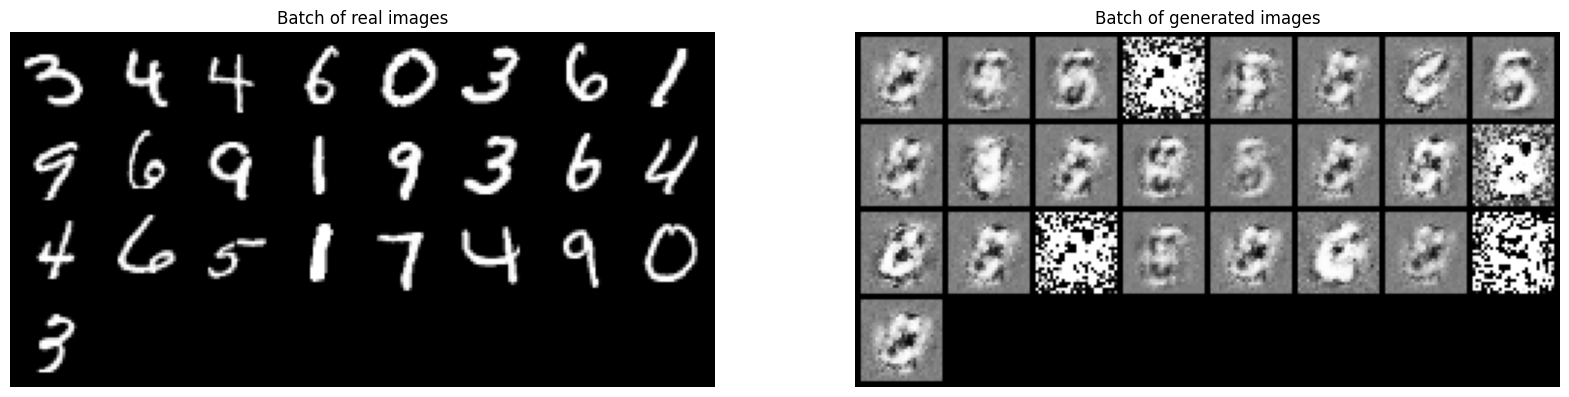

Epoch 8. Generator loss: 54635.76717662811. Discriminator loss: 170.6418346943119. Average D(x): 0.9806933587392171. Average D(G(z)): 0.01915486616882066
FID score for random batch: 400.37435105483655
Epoch 9. Generator loss: 49213.04604434967. Discriminator loss: 158.79169201518033. Average D(x): 0.9821870891571045. Average D(G(z)): 0.017512242022813974
FID score for random batch: 388.83395485503365
Epoch 10. Generator loss: 55501.99747276306. Discriminator loss: 137.55664801180816. Average D(x): 0.9844188649813335. Average D(G(z)): 0.015408367381324008
FID score for random batch: 364.2968373493385


<Figure size 2000x2000 with 0 Axes>

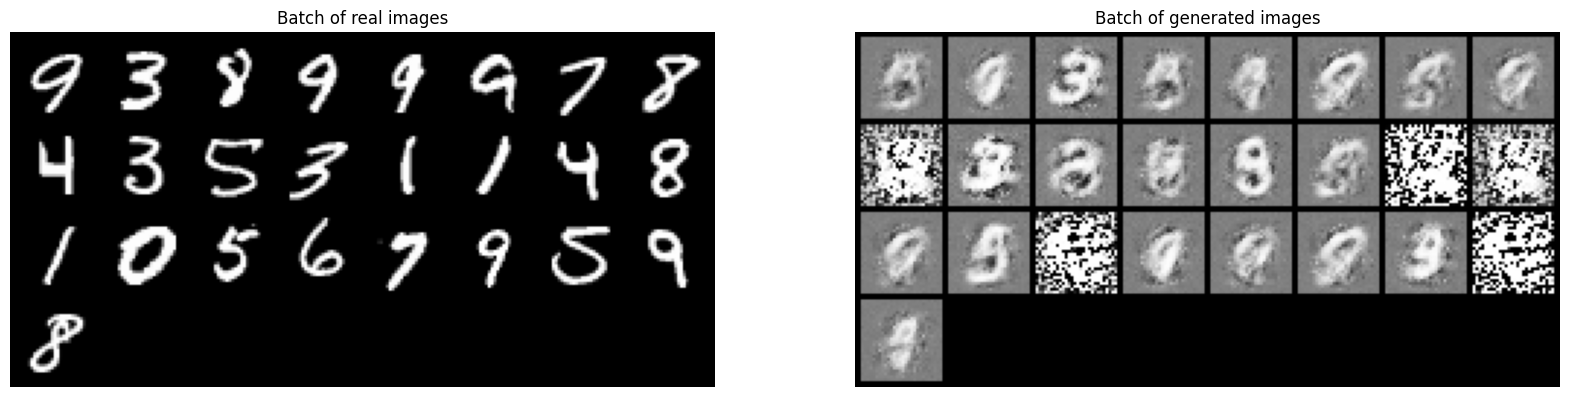

Epoch 11. Generator loss: 99607.63341617584. Discriminator loss: 106.01502799482932. Average D(x): 0.9883146313031514. Average D(G(z)): 0.011561354701254595
FID score for random batch: 421.6503373541575
Epoch 12. Generator loss: 234791.6869354248. Discriminator loss: 421.4648757956959. Average D(x): 0.9991491058985392. Average D(G(z)): 0.002365102906483892
FID score for random batch: 421.5606974906571
Epoch 13. Generator loss: 238824.0343093872. Discriminator loss: 6.182391165074065. Average D(x): 0.9995258370717367. Average D(G(z)): 0.00030504152762932346
FID score for random batch: 401.6150022906317


<Figure size 2000x2000 with 0 Axes>

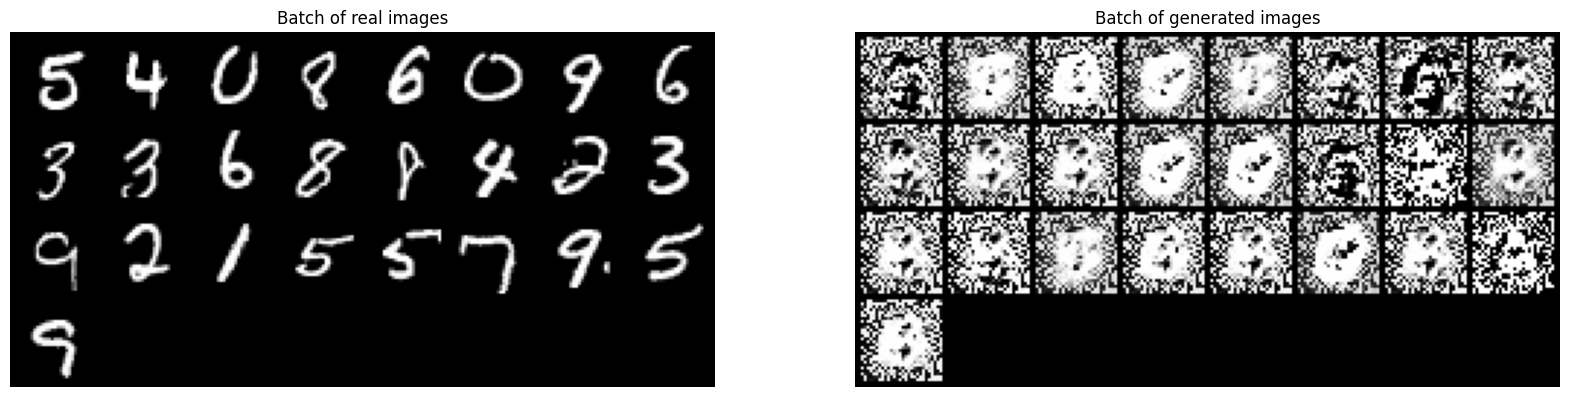

Epoch 14. Generator loss: 158046.27675437927. Discriminator loss: 81897.08164618537. Average D(x): 0.9991293374697368. Average D(G(z)): 0.3412208161742022
FID score for random batch: 396.9807723930124
Epoch 15. Generator loss: 239623.4726638794. Discriminator loss: 342.0158930847997. Average D(x): 0.999857437801361. Average D(G(z)): 0.0014421060052240105
FID score for random batch: 398.79963790063607
Epoch 16. Generator loss: 239441.77115631104. Discriminator loss: 555.2082233846388. Average D(x): 0.9994220283031464. Average D(G(z)): 0.002150107537887355
FID score for random batch: 375.1739887857807


<Figure size 2000x2000 with 0 Axes>

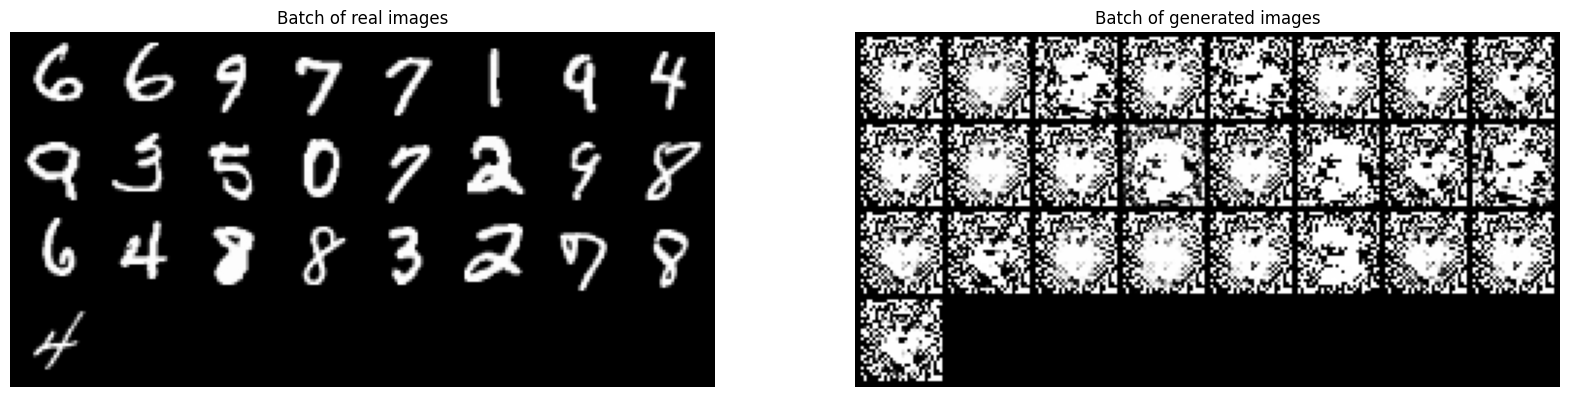

Epoch 17. Generator loss: 239607.40685272217. Discriminator loss: 413.46700329636775. Average D(x): 0.999550675590833. Average D(G(z)): 0.0015168921525649855
FID score for random batch: 385.77277935946705
Epoch 18. Generator loss: 239756.83712005615. Discriminator loss: 230.62576193662997. Average D(x): 0.9996264475822448. Average D(G(z)): 0.0009343423943386729
FID score for random batch: 392.36116447872143
Epoch 19. Generator loss: 239948.6775970459. Discriminator loss: 48.667705614823824. Average D(x): 0.9999400714556376. Average D(G(z)): 0.00021640989456328974
FID score for random batch: 390.39243548829813


<Figure size 2000x2000 with 0 Axes>

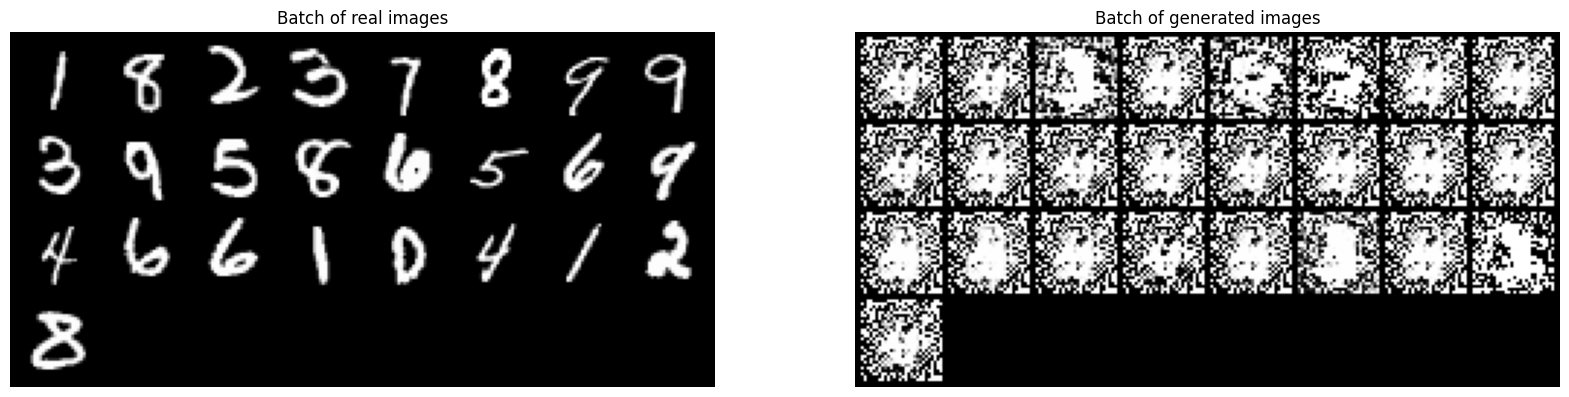

Epoch 20. Generator loss: 239952.0. Discriminator loss: 48.0. Average D(x): 1.0. Average D(G(z)): 0.0002
FID score for random batch: 396.9467885293057
Epoch 21. Generator loss: 239941.40574645996. Discriminator loss: 56.0. Average D(x): 1.0. Average D(G(z)): 0.00023333333333333333
FID score for random batch: 387.4953581322427
Epoch 22. Generator loss: 239859.84381866455. Discriminator loss: 128.00000000074874. Average D(x): 1.0. Average D(G(z)): 0.000533333333645308
FID score for random batch: 386.1516748812216


<Figure size 2000x2000 with 0 Axes>

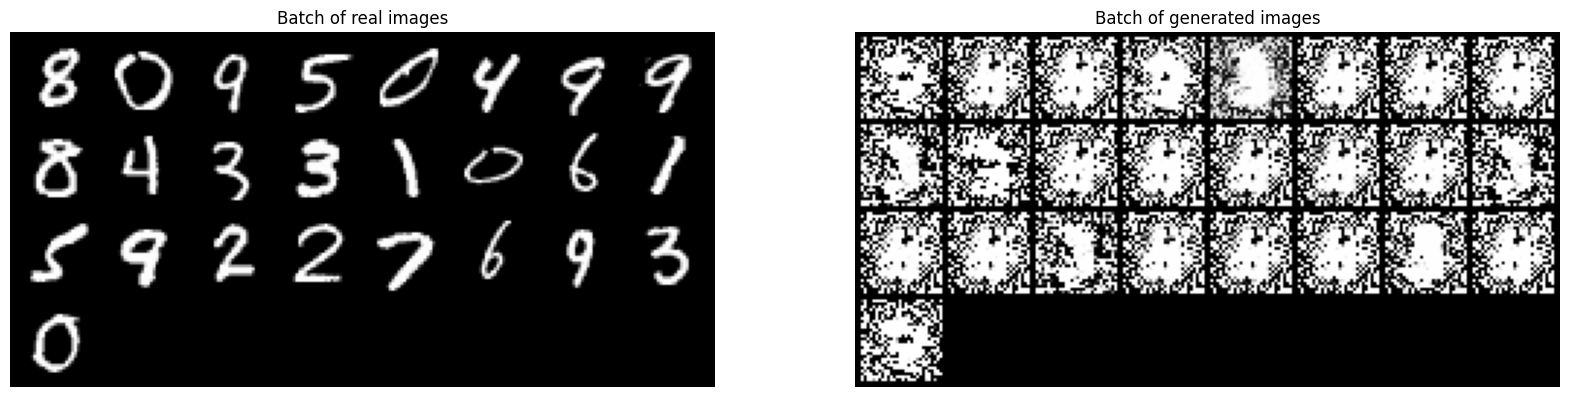

Epoch 23. Generator loss: 239640.07823944092. Discriminator loss: 350.6820549367079. Average D(x): 0.9998560679753622. Average D(G(z)): 0.0014331760338022023
FID score for random batch: 428.6400094609599
Epoch 24. Generator loss: 239878.4902496338. Discriminator loss: 158.3510947068644. Average D(x): 0.9997710362434388. Average D(G(z)): 0.0005020311214029789
FID score for random batch: 403.3134118753308
Epoch 25. Generator loss: 239985.25091552734. Discriminator loss: 12.000000000000002. Average D(x): 1.0. Average D(G(z)): 5.0000000000000436e-05
FID score for random batch: 440.61906261201585


<Figure size 2000x2000 with 0 Axes>

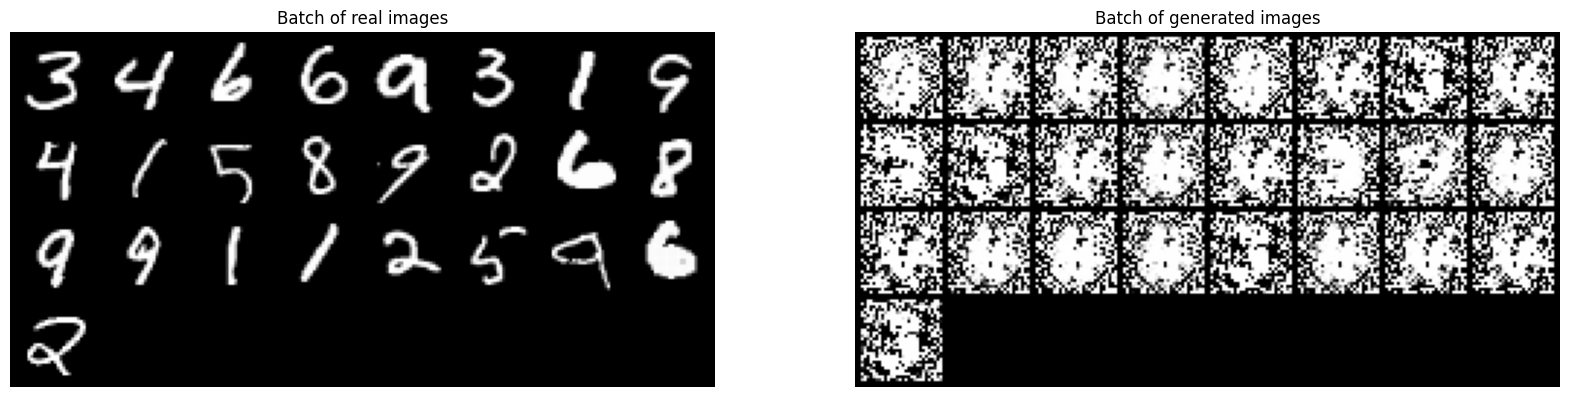

Epoch 26. Generator loss: 239952.0. Discriminator loss: 48.0. Average D(x): 1.0. Average D(G(z)): 0.0002
FID score for random batch: 421.67514486309665
Epoch 27. Generator loss: 213173.24899291992. Discriminator loss: 27665.89374932393. Average D(x): 0.9960583164056143. Average D(G(z)): 0.11161666549450203
FID score for random batch: 407.3821203818567
Epoch 28. Generator loss: 231994.0184173584. Discriminator loss: 8108.842326393724. Average D(x): 0.999535036277771. Average D(G(z)): 0.033383333325386046
FID score for random batch: 396.24015300043726


<Figure size 2000x2000 with 0 Axes>

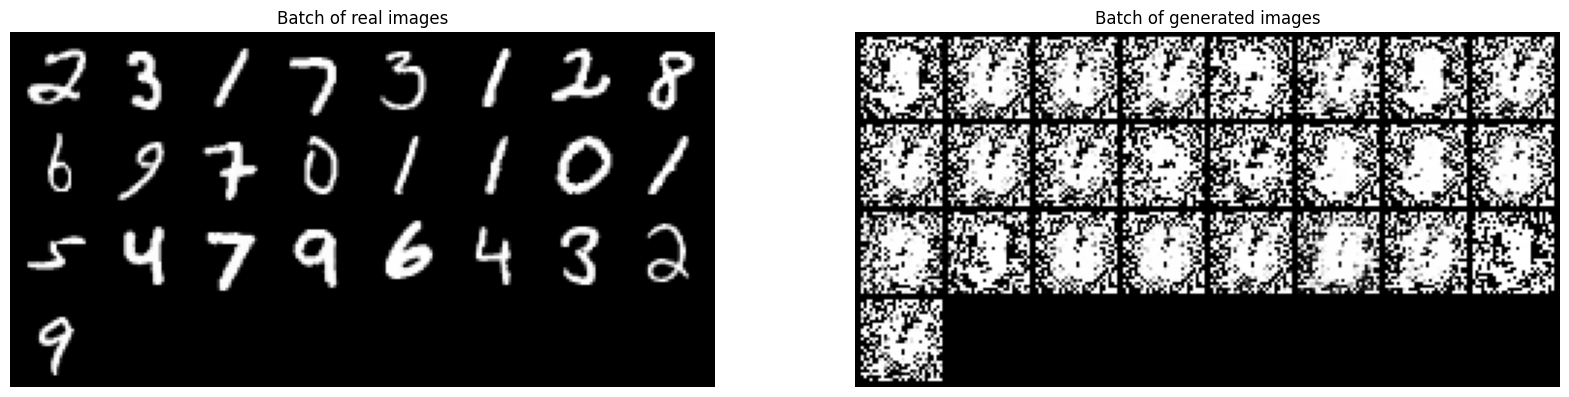

Epoch 29. Generator loss: 239968.0. Discriminator loss: 89.30745385885339. Average D(x): 0.9997333332061767. Average D(G(z)): 0.00013333333333333334
FID score for random batch: 398.6938967400631
Epoch 30. Generator loss: 239960.0. Discriminator loss: 40.0. Average D(x): 1.0. Average D(G(z)): 0.00016666666666666666
FID score for random batch: 389.16578827263316
Epoch 31. Generator loss: 239952.0. Discriminator loss: 48.0. Average D(x): 1.0. Average D(G(z)): 0.0002
FID score for random batch: 408.37663881161154


<Figure size 2000x2000 with 0 Axes>

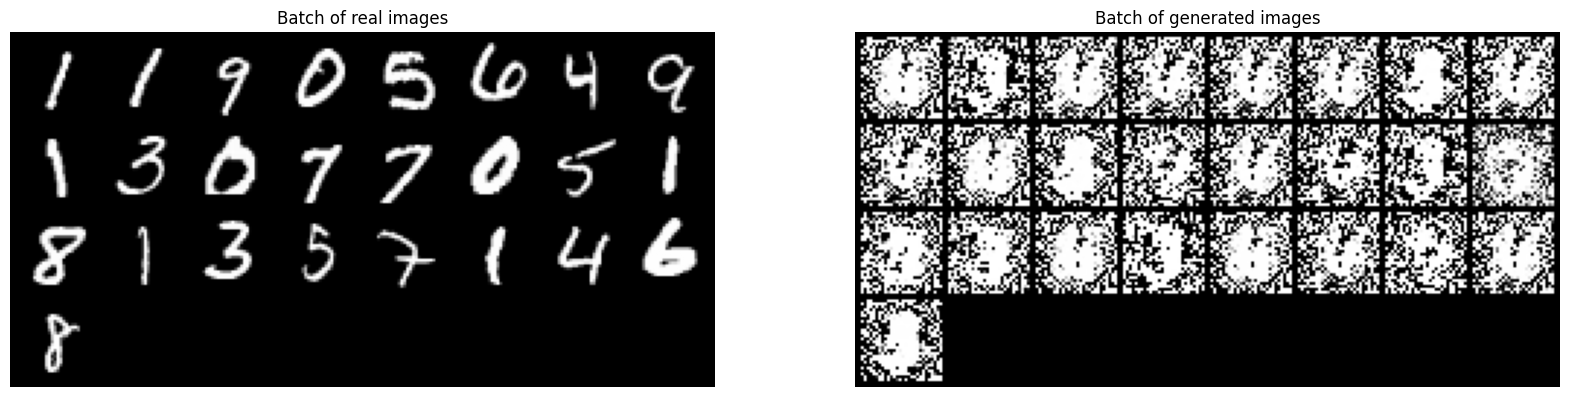

Epoch 32. Generator loss: 239976.0. Discriminator loss: 24.0. Average D(x): 1.0. Average D(G(z)): 0.0001
FID score for random batch: 392.00708557049825
Epoch 33. Generator loss: 239964.0. Discriminator loss: 36.0. Average D(x): 1.0. Average D(G(z)): 0.00015
FID score for random batch: 408.58316902499166
Epoch 34. Generator loss: 239960.0. Discriminator loss: 40.0. Average D(x): 1.0. Average D(G(z)): 0.00016666666666666666
FID score for random batch: 395.1597873529527


<Figure size 2000x2000 with 0 Axes>

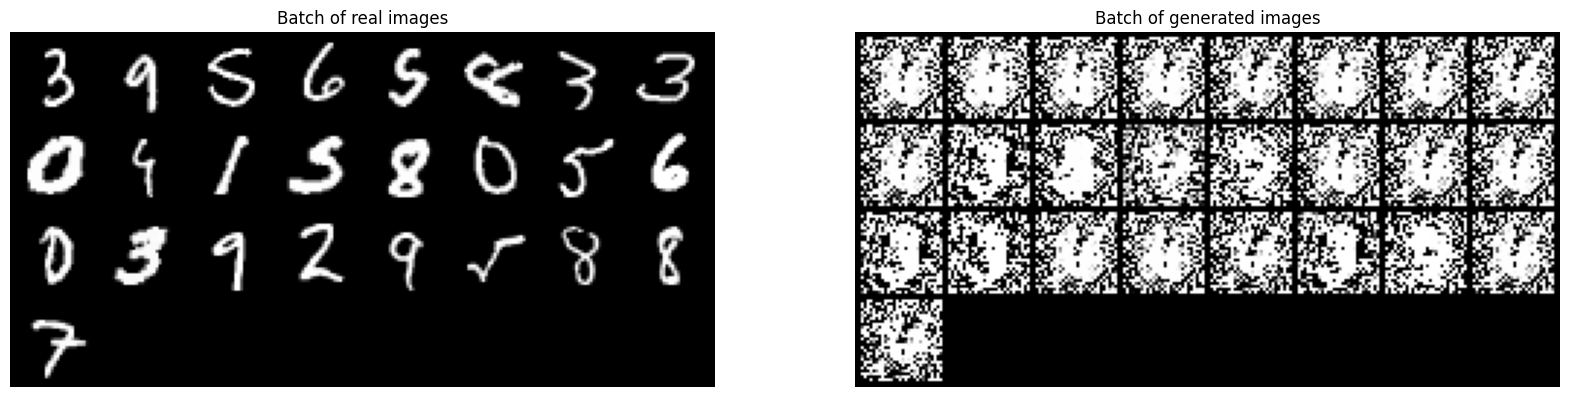

Epoch 35. Generator loss: 239936.0. Discriminator loss: 64.0. Average D(x): 1.0. Average D(G(z)): 0.0002666666666666667
FID score for random batch: 391.0985916386052
Epoch 36. Generator loss: 239952.0. Discriminator loss: 48.0. Average D(x): 1.0. Average D(G(z)): 0.0002
FID score for random batch: 418.4986708352209
Epoch 37. Generator loss: 239944.0. Discriminator loss: 56.0. Average D(x): 1.0. Average D(G(z)): 0.00023333333333333333
FID score for random batch: 409.67042384441356


<Figure size 2000x2000 with 0 Axes>

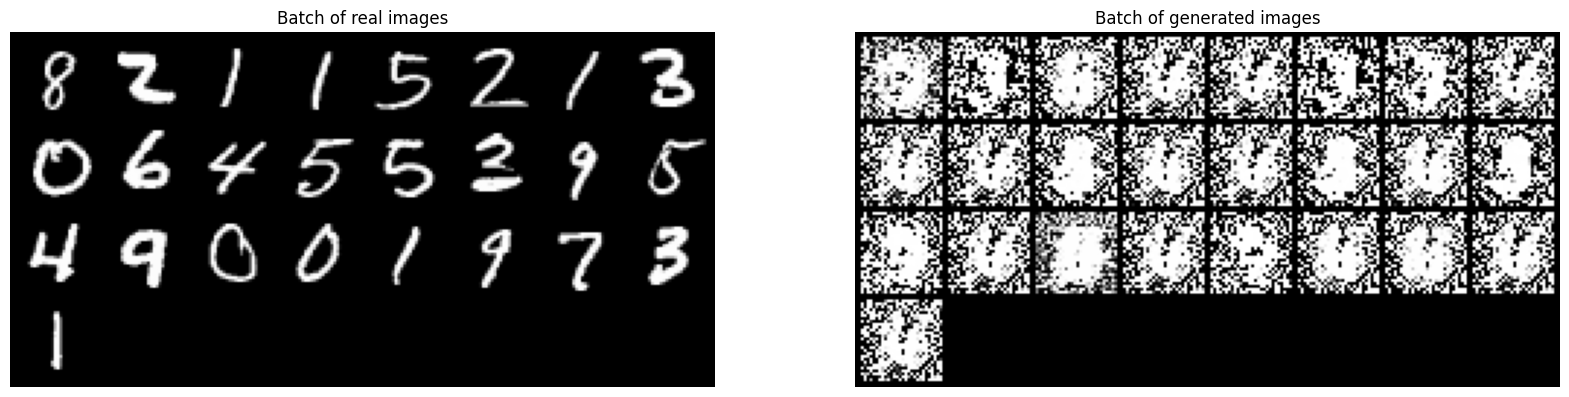

Epoch 38. Generator loss: 239948.0. Discriminator loss: 52.0. Average D(x): 1.0. Average D(G(z)): 0.00021666666666666666
FID score for random batch: 397.53730191938666
Epoch 39. Generator loss: 239944.0. Discriminator loss: 56.0. Average D(x): 1.0. Average D(G(z)): 0.00023333333333333333
FID score for random batch: 409.4138237178752
Epoch 40. Generator loss: 239968.0. Discriminator loss: 32.0. Average D(x): 1.0. Average D(G(z)): 0.00013333333333333334
FID score for random batch: 403.26072806383536


<Figure size 2000x2000 with 0 Axes>

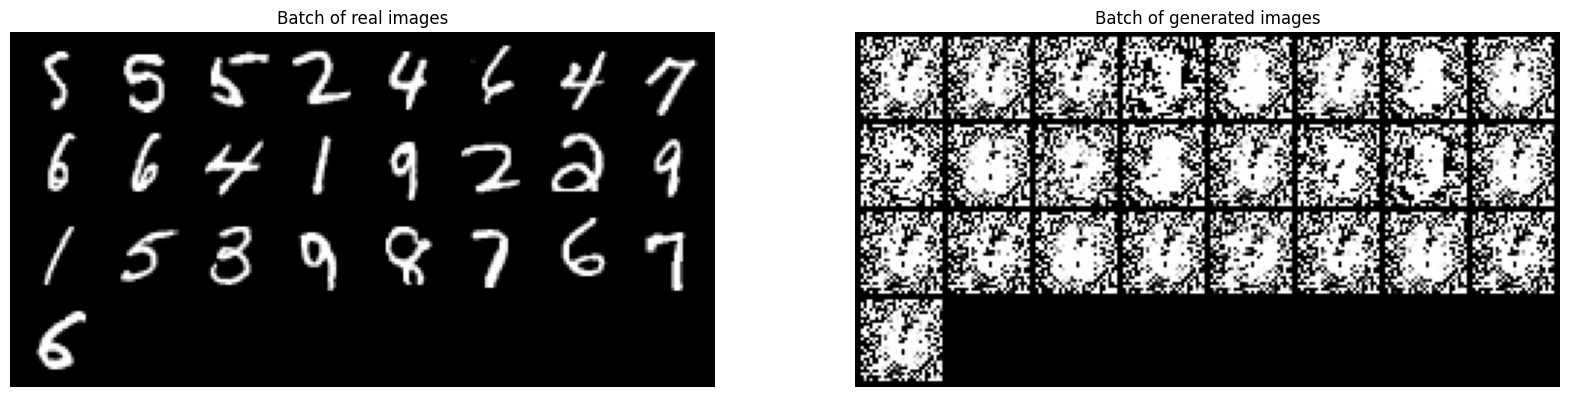

In [19]:
# train for 1h
D_losses, D_reals, D_fakes, G_losses, fid, num_epochs = train(num_epochs,
                                                         D_losses,
                                                         D_reals,
                                                         D_fakes,
                                                         G_losses,
                                                         fid,
                                                         max_time_sec=60*60)

### 3.3 Plot evolution of metrics

<Figure size 1000x1000 with 0 Axes>

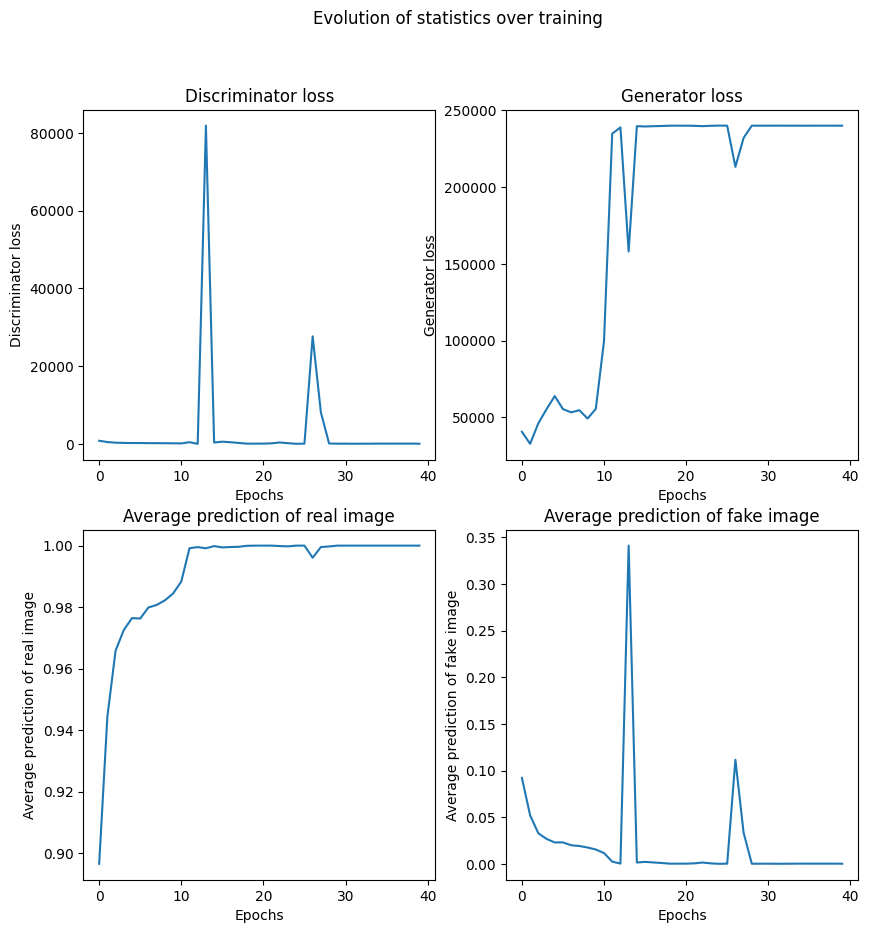

In [20]:
# plot loss evolution

plt.rcParams["figure.figsize"] = (10, 10)
plt.subplots_adjust(wspace=1.0, hspace=1.0)

fig, ax = plt.subplots(2, 2)
fig.suptitle("Evolution of statistics over training")
for i, stat, name in zip(range(4), 
                         [D_losses, G_losses, D_reals, D_fakes], 
                         ["Discriminator loss", "Generator loss", "Average prediction of real image", "Average prediction of fake image"]):
    ax[i // 2, i % 2].set_title(name)
    ax[i // 2, i % 2].set_xlabel("Epochs")
    ax[i // 2, i % 2].set_ylabel(name)
    ax[i // 2, i % 2].plot(range(num_epochs), stat)

plt.show()

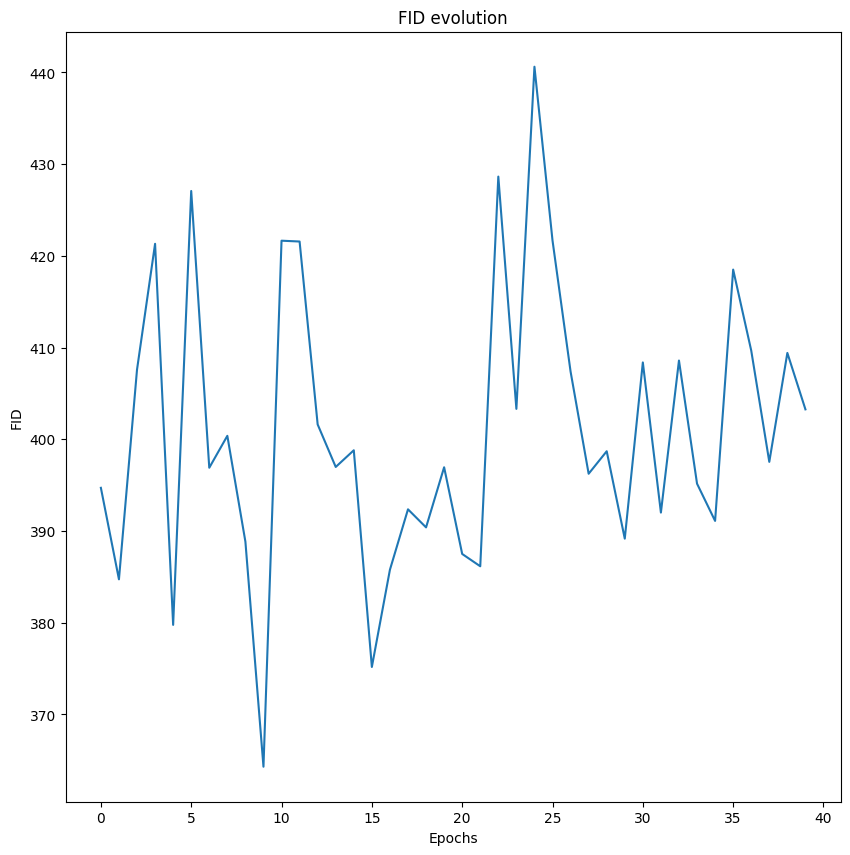

In [21]:
# plot FID evolution

plt.rcParams["figure.figsize"] = (10, 10)
plt.subplots_adjust(wspace=1.0, hspace=1.0)

plt.title("FID evolution")
plt.xlabel("Epochs")
plt.ylabel("FID")
plt.plot(range(num_epochs), fid)

## 4. Visualizing real/generated images (side by side)

<Figure size 2000x2000 with 0 Axes>

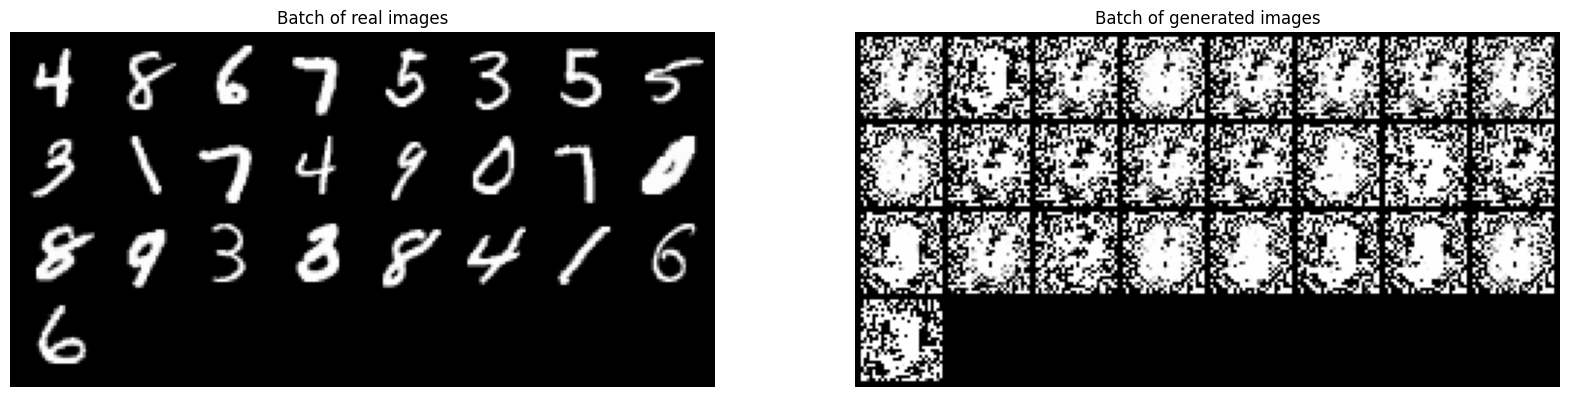

In [22]:
img_batch, labels_batch = next(iter(dl))
plot_side_by_side(img_batch, labels_batch)